In [1]:
# add necessary libraries
import pandas as pd
from numpy import mean
from numpy import std
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split,RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_recall_curve
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from xgboost.sklearn import XGBClassifier 




 

In [2]:
#look at the data

file_name = 'D:\Zeynep Yetistiren\pythonProgramming\interviews\CaseStudyData_2020.xlsx'
dataframe = pd.read_excel(file_name, engine= 'openpyxl')

# summarize the shape of the dataset
print(dataframe.shape)
# summarize the class distribution
target = dataframe.values[:,1]

counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

(34584, 52)
Class=0, Count=32935, Percentage=95.232%
Class=1, Count=1649, Percentage=4.768%


In [3]:
# load the dataset
def load_dataset(full_path):
    
    # load the dataset as a dataframe
    dataframe = pd.read_excel(file_name, engine= 'openpyxl')
    
    # split into inputs and outputs
    X = dataframe.iloc[:, 2:]
    y = dataframe.iloc[:,1]
    
    #transform Y/N inputs as 1/0 manually
    #this can be done with one_hot encoding but it would increase feature size
    Y_N_columns = ['Var_3', 'Var_11', 'Var_14','Var_15','Var_35','Var_37', 'Var_44','Var_45','Var_48','Var_49','Var_50']

    for column in Y_N_columns:
        X[column] = X[column].astype(str).replace({'N': 0, 'Y': 1, 'nan': 0.5}).astype(int)


    # select categorical and numerical features
    cat_ix = np.array(X.select_dtypes(include=['object', 'bool']).columns)
    num_ix = np.array(X.select_dtypes(include=['int64', 'float64']).columns)
    
    return X, y, cat_ix, num_ix


#get inputs, target, categorical and numerical indexes
x , y , cat_ix , num_ix = load_dataset(file_name)


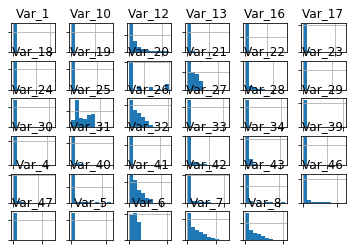

In [4]:
# select a subset of the dataframe with the chosen columns
#subset = dataframe['Target']
subset = dataframe[num_ix]


# create a histogram plot of numeric variable
ax = subset.hist()

# disable axis labels to avoid the clutter
for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])

plt.show()
# show the plot


In [5]:
#delete columns with too much null values

row_len, col_len = x.shape
print("x shape", x.shape)

empty_count = 0


for variable in x.columns:

    #find null values in columns
    empty_count = row_len - x[variable].count()

    
    # drop columns with more than 70% null values
    if empty_count > 24000:
        
        print("deleting ", variable)
        del x[variable]
        

#fill rest null columns with mean values
x = x.fillna(x.mean())

x.describe()

x shape (34584, 50)
deleting  Var_6
deleting  Var_33
deleting  Var_38
deleting  Var_40
deleting  Var_41
deleting  Var_42
deleting  Var_43
deleting  Var_46


,Var_1,Var_3,Var_4,Var_5,Var_7,Var_8,Var_10,Var_11,Var_12,Var_13,...,Var_34,Var_35,Var_37,Var_39,Var_44,Var_45,Var_47,Var_48,Var_49,Var_50
count,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,3.458400e+04,34584.000000,34584.000000,34584.000000,...,34584.000000,34584.000000,34584.000000,3.458400e+04,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000
mean,0.099352,0.180372,1790.202504,3.448994,73.428435,1983.583998,2.418822e+03,0.042621,9.882986,0.540279,...,3.589145,0.036982,0.004540,2.439989e+03,0.453707,0.011942,0.002863,0.018448,0.059854,0.483229
std,0.424117,0.384503,2963.322358,5.224116,68.804426,2096.732056,3.414379e+04,0.202004,10.683073,1.321713,...,4.209796,0.188721,0.067225,3.536319e+04,0.497860,0.108626,0.079162,0.134566,0.237220,0.499726
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,13.000000,32.000000,0.000000e+00,0.000000,3.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1500.000000,2.000000,56.000000,1356.000000,2.000000e+00,0.000000,7.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1790.202504,4.000000,117.000000,3307.000000,1.130000e+02,0.000000,12.000000,1.000000,...,5.000000,0.000000,0.000000,7.200000e+01,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,11.000000,1.000000,80000.000000,231.000000,350.000000,10657.000000,4.170043e+06,1.000000,61.000000,45.000000,...,58.000000,1.000000,1.000000,4.187941e+06,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000


In [6]:
#transform categorical values


def one_hot(data,cols_to_encode):
    
    print("one hot encoding : ",cols_to_encode)
    new_data = pd.get_dummies(data = data, columns = cols_to_encode, prefix=cols_to_encode) 

    return new_data



#categorical variables
cat_ix = np.array(x.select_dtypes(include=['object', 'bool']).columns)
#transform them
x = one_hot(x,(cat_ix))
x.describe()

['Var_2' 'Var_9' 'Var_36']


,Var_1,Var_3,Var_4,Var_5,Var_7,Var_8,Var_10,Var_11,Var_12,Var_13,...,Var_36_1,Var_36_2,Var_36_3,Var_36_4,Var_36_6,Var_36_8,Var_36_D,Var_36_L,Var_36_U,Var_36_X
count,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,3.458400e+04,34584.000000,34584.000000,34584.000000,...,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000
mean,0.099352,0.180372,1790.202504,3.448994,73.428435,1983.583998,2.418822e+03,0.042621,9.882986,0.540279,...,0.412734,0.123988,0.026689,0.001793,0.000029,0.006072,0.002660,0.018217,0.044211,0.055054
std,0.424117,0.384503,2963.322358,5.224116,68.804426,2096.732056,3.414379e+04,0.202004,10.683073,1.321713,...,0.492333,0.329573,0.161174,0.042303,0.005377,0.077688,0.051509,0.133736,0.205567,0.228090
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,13.000000,32.000000,0.000000e+00,0.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1500.000000,2.000000,56.000000,1356.000000,2.000000e+00,0.000000,7.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1790.202504,4.000000,117.000000,3307.000000,1.130000e+02,0.000000,12.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11.000000,1.000000,80000.000000,231.000000,350.000000,10657.000000,4.170043e+06,1.000000,61.000000,45.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
#normalize data becasue it perform better, converge faster

normalized_df=(x-x.min())/(x.max()-x.min())

normalized_df.describe()

,Var_1,Var_3,Var_4,Var_5,Var_7,Var_8,Var_10,Var_11,Var_12,Var_13,...,Var_36_1,Var_36_2,Var_36_3,Var_36_4,Var_36_6,Var_36_8,Var_36_D,Var_36_L,Var_36_U,Var_36_X
count,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,3.458400e+04,34584.000000,34584.000000,34584.000000,...,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000
mean,0.009032,0.180372,0.022378,0.014931,0.209796,0.186130,5.800473e-04,0.042621,0.162016,0.012006,...,0.412734,0.123988,0.026689,0.001793,0.000029,0.006072,0.002660,0.018217,0.044211,0.055054
std,0.038556,0.384503,0.037042,0.022615,0.196584,0.196747,8.187875e-03,0.202004,0.175132,0.029371,...,0.492333,0.329573,0.161174,0.042303,0.005377,0.077688,0.051509,0.133736,0.205567,0.228090
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.004329,0.037143,0.003003,0.000000e+00,0.000000,0.049180,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.018750,0.008658,0.160000,0.127240,4.796114e-07,0.000000,0.114754,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.022378,0.017316,0.334286,0.310312,2.709804e-05,0.000000,0.196721,0.022222,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
#calculate correlation between target and variables

dropped_vars = []


for var in normalized_df.columns:



    correlation = y.corr(normalized_df[var])
    
    print("correlation with target %",round(100*abs(correlation),3) ," ", var)
    
    #if correlation with target is smaller than %1 it is unnecessary and deleted
    if abs(correlation) < 0.01:
        
        del normalized_df[var]

#find correlation between features
cor_table = abs(normalized_df.corr(method ='kendall'))


#find correlations higher than %80 between features 

high_cor_double = cor_table.where((cor_table != 1) & (cor_table > 0.8)).stack().index.values

# Sorting tuple then eliminating equal combinations
high_cor = set(tuple(sorted(x)) for x in high_cor_double) 
  
#for each high correlated pair of columns
for var in high_cor:
    
    #delete one of the paired variables
    del normalized_df[var[1]]
    
normalized_df.describe()

correlation with target % 6.18   Var_1
correlation with target % 7.925   Var_3
correlation with target % 4.451   Var_4
correlation with target % 9.859   Var_5
correlation with target % 8.601   Var_7
correlation with target % 8.194   Var_8
correlation with target % 1.454   Var_10
correlation with target % 2.198   Var_11
correlation with target % 1.446   Var_12
correlation with target % 10.37   Var_13
correlation with target % 3.525   Var_14
correlation with target % 2.701   Var_15
correlation with target % 0.532   Var_16
correlation with target % 3.296   Var_17
correlation with target % 1.449   Var_18
correlation with target % 0.374   Var_19
correlation with target % 1.539   Var_20
correlation with target % 0.173   Var_21
correlation with target % 0.999   Var_22
correlation with target % 0.177   Var_23
correlation with target % 0.014   Var_24
correlation with target % 0.268   Var_25
correlation with target % 1.97   Var_26
correlation with target % 0.364   Var_27
correlation with target 

,Var_1,Var_4,Var_5,Var_7,Var_10,Var_11,Var_12,Var_13,Var_14,Var_15,...,Var_2_3,Var_2_L,Var_9_A,Var_9_R,Var_36_1,Var_36_2,Var_36_8,Var_36_L,Var_36_U,Var_36_X
count,34584.000000,34584.000000,34584.000000,34584.000000,3.458400e+04,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,...,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000,34584.000000
mean,0.009032,0.022378,0.014931,0.209796,5.800473e-04,0.042621,0.162016,0.012006,0.368292,0.765730,...,0.010843,0.161635,0.421438,0.296814,0.412734,0.123988,0.006072,0.018217,0.044211,0.055054
std,0.038556,0.037042,0.022615,0.196584,8.187875e-03,0.202004,0.175132,0.029371,0.482348,0.423548,...,0.103566,0.368121,0.493797,0.456860,0.492333,0.329573,0.077688,0.133736,0.205567,0.228090
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.004329,0.037143,0.000000e+00,0.000000,0.049180,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.018750,0.008658,0.160000,4.796114e-07,0.000000,0.114754,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.022378,0.017316,0.334286,2.709804e-05,0.000000,0.196721,0.022222,1.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
#decreasing insignificant columns


#find most 10 important features
fs = SelectKBest(score_func = chi2, k = 10) 
fs.fit(normalized_df, y)


# add column names
new_col_idx = fs.get_support(indices=True)


x = normalized_df.iloc[:,new_col_idx]


print(x.shape)

(34584, 10)


In [11]:

# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

print("x_train: ", x_train.shape, "x_test", x_test.shape)

x_train:  (24208, 10) x_test (10376, 10)


In [12]:
#since classes are imbalanced, equalize the samples

oversample = SMOTE()

x_train, y_train = oversample.fit_resample(x_train, y_train)

#show number of samples for each class
counter = Counter(y_train)
print(counter)

Counter({0: 23062, 1: 23062})


Text(0,0.5,'variables')

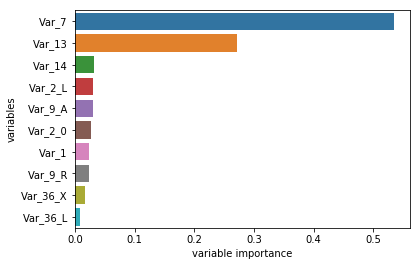

In [13]:
#ploting importance of features 

model = DecisionTreeClassifier(max_depth = 35).fit(x_train, y_train)

feature_imp = pd.Series(model.feature_importances_, index = x_train.columns).sort_values(ascending = False)

sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel("variable importance")
plt.ylabel("variables")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


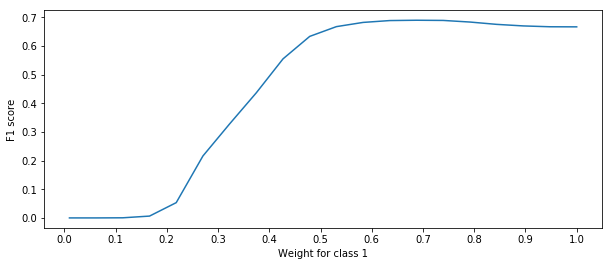

In [14]:
#since data is imbalanced, 
#find best weights for each class for training then plot 

lr = LogisticRegression(solver='newton-cg')# or DecisionTreeClassifier or RandomForestClassifier

#range for weights
weights = np.linspace(0.0,0.99,20)

#dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(x_train, y_train)

#Ploting the score for different values of weight
plt.figure(figsize=(10,4))

weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])

plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.show()

Logistic Regression confusion matrix: 
 [[2983 6890]
 [  47  456]]
f1=0.116 auc=0.109 

LinearDiscriminantAnalysis confusion matrix: 
 [[6193 3680]
 [ 187  316]]
f1=0.140 auc=0.108 

KNN confusion matrix: 
 [[9488  385]
 [ 468   35]]
f1=0.076 auc=0.098 

DecisionTreeClassifier confusion matrix: 
 [[8702 1171]
 [ 412   91]]
f1=0.103 auc=0.099 

Naive Bayes confusion matrix: 
 [[6380 3493]
 [ 210  293]]
f1=0.137 auc=0.097 

[15:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgb classifier confusion matrix: 
 [[9186  687]
 [ 459   44]]
f1=0.071 auc=0.061 

GradientBoostingClassifier confusion matrix: 
 [[8158 1715]
 [ 332  171]]
f1=0.143 auc=0.083 

RandomForestClassifier confusion matrix: 
 [[8753 1120]
 [ 421   82]]
f1=0.096 auc=0.0

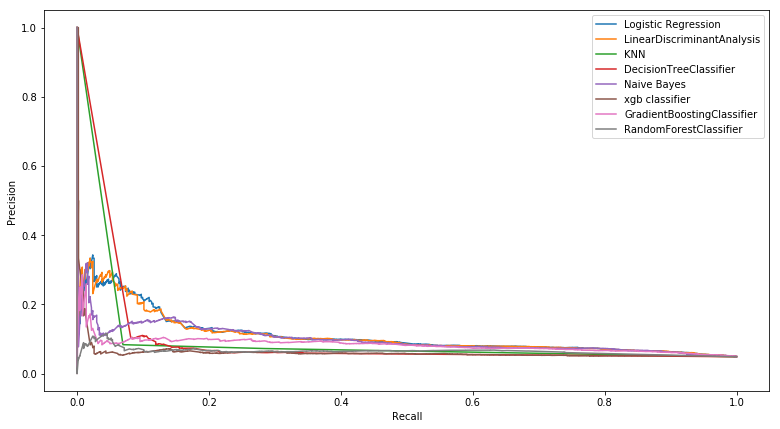

In [15]:
#testing different models
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear', max_iter = 1000 , class_weight={0: 0.35, 1: 0.65})))
models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=2)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier(class_weight={0: 0.4, 1: 0.6},max_depth = 35)))
models.append(('Naive Bayes', GaussianNB()))
#models.append(('SVM', SVC()))
models.append(('xgb classifier', XGBClassifier(use_label_encoder=False)))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier(class_weight={0: 0.4, 1: 0.6})))

plt.figure(figsize=(13,7))


for name, model in models:

    #train and test each model
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    #show evaluation results
    #con matrix, auc and f1 score is used since data is imbalanced
    
    print(name,"confusion matrix: \n",confusion_matrix(y_test,y_pred))
    
    probs = model.predict_proba(x_test)
    
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    
    # predict class values
    y_pred = model.predict(x_test)
    
    precision, recall, _ = precision_recall_curve(y_test, probs)
    f1 = f1_score(y_test, y_pred)
    auc_ = auc(recall, precision)
    
    # summarize scores
    print('f1=%.3f auc=%.3f' % (f1, auc_),"\n")
    plt.plot(recall, precision, label=name)

    
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

    

In [16]:
# also evaluate using cross validation and k-fold but
#when oversamplied data used, it gives too good results 

model = LogisticRegression(solver='newton-cg')

#split to folds
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# evaluate model
scores = cross_val_score(model, x_train, y_train, scoring='f1', cv=cv, n_jobs=-1)

# summarize performance
print('Mean f1: %.3f \n' % np.mean(scores))

Mean f1: 0.648 



In [ ]:
#notes

#accuracy and roc curve are too optimistic on imbalanced datasets
